In [1]:
import json
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
# %%bash
# cd ../../pipelines/research-mhqa-evaluation/
# mv experiment-results.json experiment-results.json.bak
# dvc exp show -n 3 --json > experiment-results.json

In [3]:
from bellek.dvc.experiment import load_experiments

experiments = load_experiments('../../pipelines/research-mhqa-evaluation/experiment-results.json')
print(f"{len(experiments)} experiments")
experiments[0]

75 experiments


{'commit': 'workspace',
 'id': 'workspace',
 'name': None,
 'params': {'dataset': {'path': 'bdsaglam/musique',
   'name': 'answerable',
   'split': 'validation'},
  'qa': {'prompt': 'standard', 'model': 'llama-3-70b-tgi', 'temperature': 0.7},
  'run': 1},
 'metrics': {'exact_match': 0.5, 'f1': 0.6599999999999999, 'fuzzy_match': 0.7}}

In [4]:
valid_experiments = [
    experiment
    for experiment in experiments
    if experiment["params"].get("qa")
]
len(valid_experiments)

75

In [5]:
df = (
    pd.json_normalize(valid_experiments)
    .sort_values(["params.qa.model", "params.qa.prompt", "params.qa.temperature", "params.run"])
    .drop(columns=["commit", "id"])
)
dataset_path = "bdsaglam/musique"
mask = (df["params.dataset.path"] == dataset_path) & (df["params.dataset.split"] == "validation")
df = df.loc[mask].reset_index(drop=True)
df.drop_duplicates(inplace=True)
df

,name,params.dataset.path,params.dataset.name,params.dataset.split,params.qa.prompt,params.qa.model,params.qa.temperature,params.run,metrics.exact_match,metrics.f1,metrics.fuzzy_match
0,inane-yate,bdsaglam/musique,answerable,validation,cot-fs,llama-3-70b-tgi,0.1,1,0.371949,0.440146,0.416632
1,socko-fees,bdsaglam/musique,answerable,validation,cot-fs,llama-3-70b-tgi,0.1,1,0.371949,0.440146,0.416632
2,dormy-gang,bdsaglam/musique,answerable,validation,cot-fs,llama-3-70b-tgi,0.1,2,0.371121,0.438157,0.414977
3,wally-stob,bdsaglam/musique,answerable,validation,cot-fs,llama-3-70b-tgi,0.1,3,0.364915,0.433579,0.407530
4,extra-ciao,bdsaglam/musique,answerable,validation,cot-fs,llama-3-70b-tgi,0.5,1,0.362019,0.429637,0.408357
...,...,...,...,...,...,...,...,...,...,...,...
70,drear-uvea,bdsaglam/musique,answerable,validation,standard,llama-3-70b-tgi,1.0,1,0.525859,0.641445,0.589160
71,farci-debt,bdsaglam/musique,answerable,validation,standard,llama-3-70b-tgi,1.0,1,0.525859,0.641445,0.589160
72,party-roam,bdsaglam/musique,answerable,validation,standard,llama-3-70b-tgi,1.0,2,0.526272,0.644234,0.592884
73,shaky-tugs,bdsaglam/musique,answerable,validation,standard,llama-3-70b-tgi,1.0,3,0.522962,0.638086,0.587091


In [6]:
metric_cols = [col for col in df.columns if col.startswith("metrics.")]

In [12]:
df.drop(
    columns=["name", "params.dataset.path", "params.dataset.name", "params.dataset.split", "params.qa.model"]
).groupby(["params.qa.prompt", "params.qa.temperature"]).aggregate(["mean", "max", "std", "count"]).loc[:, metric_cols]

metrics.exact_match            \
                                                      mean       max   
params.qa.prompt params.qa.temperature                                 
cot-fs           0.1                              0.369983  0.371949   
                 0.5                              0.369218  0.377327   
                 0.7                              0.370542  0.377327   
                 1.0                              0.361192  0.366984   
cot-zs           0.1                              0.361192  0.364501   
                 0.5                              0.363095  0.368225   
                 0.7                              0.354903  0.357882   
                 1.0                              0.343070  0.350021   
cte              0.1                              0.636243  0.638395   
                 0.5                              0.631499  0.632602   
                 0.7                              0.636326  0.639222   
                 1.0                              0.622121  0.622673   
standard         0.1                              0.543373  0.544063   
                 0.5                              0.536533  0.541167   
                 0.7                              0.529210  0.539098   
                 1.0                              0.524783  0.526272   

                                                       metrics.f1            \
                                             std count       mean       max   
params.qa.prompt params.qa.temperature                                        
cot-fs           0.1                    0.003401     4   0.438007  0.440146   
                 0.5                    0.006877     5   0.435770  0.440525   
                 0.7                    0.005767     5   0.441200  0.443775   
                 1.0                    0.007556     5   0.429792  0.436727   
cot-zs           0.1                    0.001896     5   0.435096  0.438870   
                 0.5                    0.004695     5   0.436414  0.442912   
                 0.7                    0.003392     5   0.429536  0.432154   
                 1.0                    0.003908     5   0.415008  0.420435   
cte              0.1                    0.001993     5   0.741937  0.743800   
                 0.5                    0.001566     3   0.738394  0.739682   
                 0.7                    0.002584     3   0.740226  0.742647   
                 1.0                    0.000632     3   0.735057  0.736246   
standard         0.1                    0.000565     6   0.651989  0.652452   
                 0.5                    0.002719     5   0.649005  0.650146   
                 0.7                    0.016411     5   0.651251  0.660000   
                 1.0                    0.001670     5   0.640659  0.644234   

                                                       metrics.fuzzy_match  \
                                             std count                mean   
params.qa.prompt params.qa.temperature                                       
cot-fs           0.1                    0.003097     4            0.413943   
                 0.5                    0.005613     5            0.414067   
                 0.7                    0.002937     5            0.416301   
                 1.0                    0.007389     5            0.405213   
cot-zs           0.1                    0.002131     5            0.405296   
                 0.5                    0.005963     5            0.405710   
                 0.7                    0.002872     5            0.397849   
                 1.0                    0.003146     5            0.385850   
cte              0.1                    0.001718     5            0.692760   
                 0.5                    0.001969     3            0.689008   
                 0.7                    0.002990     3            0.690663   
                 1.0                    0.001038     3            0.680320  

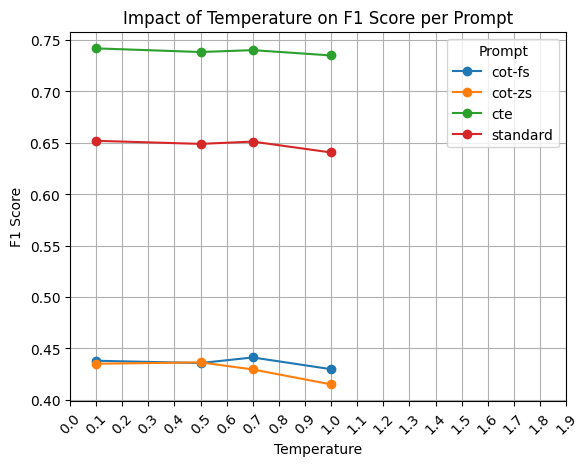

In [8]:
# Average metrics over repeated runs (params.run)
df_avg = (
    df.groupby(["params.qa.prompt", "params.qa.temperature"])[
        ["metrics.exact_match", "metrics.f1", "metrics.fuzzy_match"]
    ]
    .mean()
    .reset_index()
)

# Plotting the impact of temperature per prompt
prompts = df_avg["params.qa.prompt"].unique()

for prompt in prompts:
    subset = df_avg[df_avg["params.qa.prompt"] == prompt]
    plt.plot(subset["params.qa.temperature"], subset["metrics.f1"], marker="o", label=prompt)

plt.xlabel("Temperature")
plt.ylabel("F1 Score")
plt.title("Impact of Temperature on F1 Score per Prompt")
plt.legend(title="Prompt")
plt.xticks(ticks=list(np.arange(0, 2, 0.1)), rotation=45)  # Adding xticks for temperature values in range(0, 2, 0.1)
plt.grid(True)
plt.show()

In [9]:
# To compare the prompts at the best temperature
# Assuming "best temperature" is defined as the one with the highest average F1 score
df_best_temp = (
    df_avg.loc[df_avg.groupby("params.qa.prompt")["metrics.f1"].idxmax()]
    .set_index("params.qa.prompt", drop=False)
    .loc[["standard", "cot-zs", "cot-fs", "cte"]]
    .copy()
)
df_best_temp

,params.qa.prompt,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.fuzzy_match
params.qa.prompt,,,,,
standard,standard,0.1,0.543373,0.651989,0.607916
cot-zs,cot-zs,0.5,0.363095,0.436414,0.405710
cot-fs,cot-fs,0.7,0.370542,0.441200,0.416301
cte,cte,0.1,0.636243,0.741937,0.692760


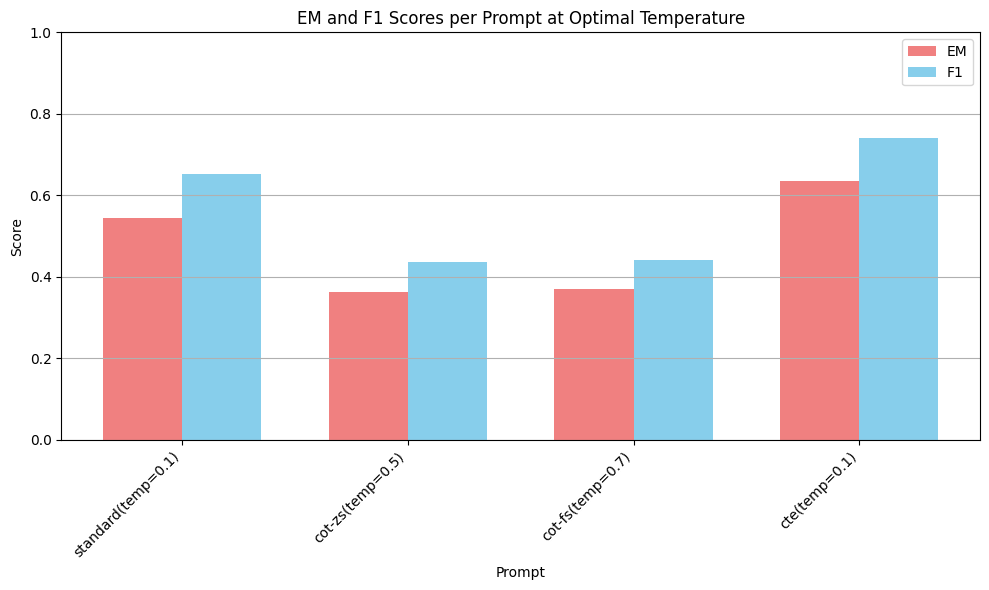

In [10]:
# Plotting EM and F1 scores together per prompt with temperature annotations
plt.figure(figsize=(10, 6))

# Create x-tick labels that include both the prompt and temperature
xs = [
    f"{prompt}(temp={temperature})"
    for prompt, temperature in zip(
        df_best_temp["params.qa.prompt"].values, df_best_temp["params.qa.temperature"].values
    )
]

# Set the width for the bars and the positions
bar_width = 0.35
index = np.arange(len(xs))

# Plot Exact Match (EM) bars
bar1 = plt.bar(index, df_best_temp["metrics.exact_match"], bar_width, label="EM", color="lightcoral")

# Plot F1 bars, shifted by bar_width for side-by-side bars
bar2 = plt.bar(index + bar_width, df_best_temp["metrics.f1"], bar_width, label="F1", color="skyblue")

# Add labels and titles
plt.xlabel('Prompt')
plt.ylabel('Score')
plt.title('EM and F1 Scores per Prompt at Optimal Temperature')

# Set x-ticks with prompt and temperature labels
plt.xticks(index + bar_width / 2, xs, rotation=45, ha='right')

# Add a legend to differentiate between EM and F1 scores
plt.legend()

# Add a grid and display the plot
plt.grid(axis='y')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

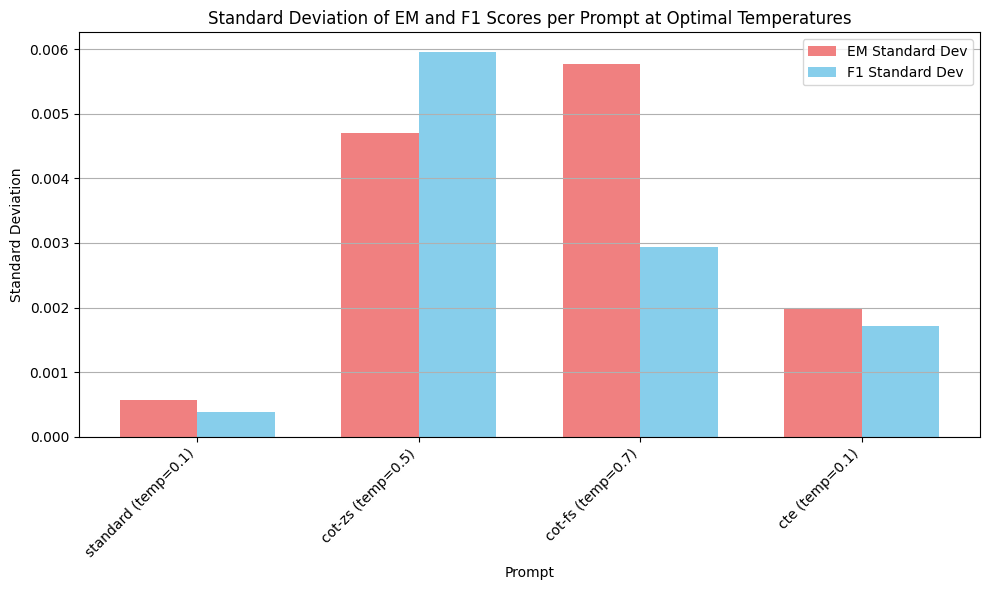

In [11]:
# Initialize an empty list to store stats
stats = []

# Loop through each prompt and its optimal temperature
for index, row in df_best_temp.iterrows():
    prompt = row['params.qa.prompt']
    optimal_temp = row['params.qa.temperature']
    
    # Select rows that correspond to the current prompt and its optimal temperature
    df_temp = df[(df['params.qa.prompt'] == prompt) & (df['params.qa.temperature'] == optimal_temp)]
    
    # Calculate stats for Exact Match and F1 scores
    em_std = df_temp['metrics.exact_match'].std()
    f1_std = df_temp['metrics.f1'].std()
    
    # Append to the list
    stats.append({
        'prompt': prompt,
        'optimal_temp': optimal_temp,
        'EM.std': em_std,
        'F1.std': f1_std
    })

# Convert the stats to a DataFrame
df_stats = pd.DataFrame(stats).set_index('prompt', drop=False).loc[['standard', 'cot-zs', 'cot-fs', 'cte']].copy()

# Combine prompt and optimal temperature for xticks
df_stats['prompt_with_temp'] = df_stats['prompt'] + " (temp=" + df_stats['optimal_temp'].astype(str) + ")"

# Plotting the stats of EM and F1 scores for each prompt
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot for EM stats
bar_width = 0.35
index = np.arange(len(df_stats))

bar1 = ax.bar(index, df_stats['EM.std'], bar_width, label='EM Standard Dev', color='lightcoral')

# Bar plot for F1 stats, offset by bar_width for side-by-side bars
bar2 = ax.bar(index + bar_width, df_stats['F1.std'], bar_width, label='F1 Standard Dev', color='skyblue')

# Add labels and titles
ax.set_xlabel('Prompt')
ax.set_ylabel('Standard Deviation')
ax.set_title('Standard Deviation of EM and F1 Scores per Prompt at Optimal Temperatures')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df_stats['prompt_with_temp'], rotation=45, ha='right')
ax.legend()

# Add a grid and display the plot
plt.grid(axis='y')
plt.tight_layout()
plt.show()
